In [1]:

import pandas as pd
import numpy as np
from env import get_db_url
import os
from sklearn.model_selection import train_test_split
import pandas as pd
from pydataset import data
from env import get_db_url
import pandas as pd
import numpy as np
import matplotlib as plt

from sklearn.preprocessing import MinMaxScaler


# MALL_CUSTOMERS

## Acquire data from the customers table in the mall_customers database.

In [2]:
def new_mall_data():
    """
    Fetches mall data from the database using SQL query.

    Returns:
    - df: DataFrame containing mall data
    """
   
    conn = get_db_url('mall_customers')

    query = '''
           SELECT *
            FROM customers;
            '''

    
    df = pd.read_sql(query, conn)
    return df

In [3]:
df = new_mall_data()

In [4]:
df

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


## Summarize the data (include distributions and descriptive statistics).

In [5]:
print(df.head())               
print(df.info())                
print(df.describe())            

   customer_id  gender  age  annual_income  spending_score
0            1    Male   19             15              39
1            2    Male   21             15              81
2            3  Female   20             16               6
3            4  Female   23             16              77
4            5  Female   31             17              40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     200 non-null    int64 
 1   gender          200 non-null    object
 2   age             200 non-null    int64 
 3   annual_income   200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       customer_id         age  annual_income  spending_score
count   200.000000  200.000000     200.000000      200.000000
mean    100.500000   38.850000      60.560000       50.

<Axes: title={'center': 'spending_score'}>

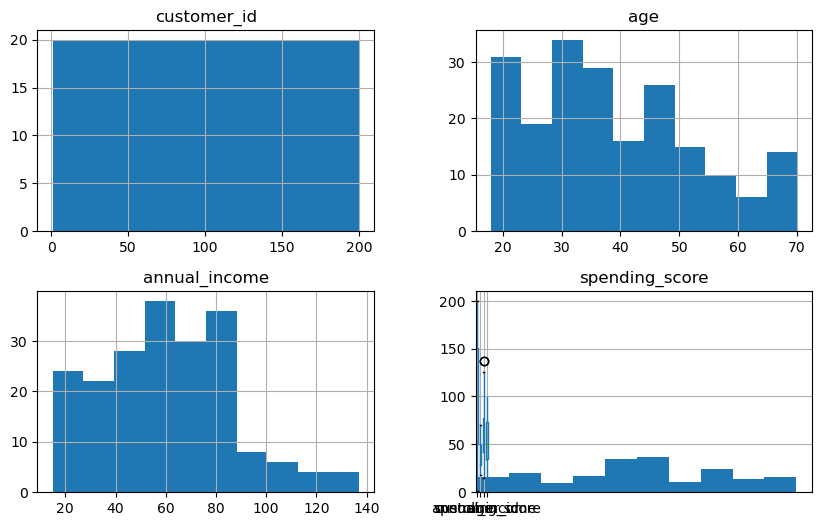

In [6]:
# Histograms
df.hist(bins=10, figsize=(10, 6))



# Box plots
df.boxplot(figsize=(10, 6))




## Detect outliers using IQR.

In [7]:
def detect_outliers_iqr(df, columns, threshold=1.5):
    """
    Detect outliers in the specified numeric column(s) of a DataFrame using the IQR method.
    
    Args:
        df (pandas.DataFrame): The DataFrame to detect outliers.
        columns (list or str): The column name(s) or list of column names to examine for outliers.
        threshold (float, optional): The threshold value to determine outliers (default is 1.5).
        
    Returns:
        pandas.DataFrame: A DataFrame containing the outliers for the specified column(s).
    """
    if isinstance(columns, str):
        columns = [columns]
    
    outliers = pd.DataFrame()
    
    for col in columns:
        # Calculate the IQR
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # Determine the outlier thresholds
        lower_threshold = q1 - threshold * iqr
        upper_threshold = q3 + threshold * iqr
        
        # Identify outliers
        outliers_col = df[(df[col] < lower_threshold) | (df[col] > upper_threshold)]
        outliers = pd.concat([outliers, outliers_col], ignore_index=True)
    
    return outliers




In [8]:
# Example usage
annual_outliers = detect_outliers_iqr(df, 'annual_income')

In [9]:
annual_outliers

,customer_id,gender,age,annual_income,spending_score
0,199,Male,32,137,18
1,200,Male,30,137,83


In [10]:
# Example usage
spending_outliers = detect_outliers_iqr(df, 'spending_score')

In [11]:
spending_outliers

,customer_id,gender,age,annual_income,spending_score


In [12]:
# Example usage
age_outliers = detect_outliers_iqr(df, 'age')

In [13]:
age_outliers

,customer_id,gender,age,annual_income,spending_score


## Split data into train, validate, and test.

In [14]:
def split_zillow_data(df):
    """
    Splits the Mall data into training, validation, and test sets.

    Arguments:
    - df: DataFrame containing Mall data

    Returns:
    - train: DataFrame of the training set
    - validate: DataFrame of the validation set
    - test: DataFrame of the test set
    """
  
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123) 
                                       

    
    return train, validate, test

In [15]:
train, validate, test = split_zillow_data(df)

In [16]:
train.head()

,customer_id,gender,age,annual_income,spending_score
123,124,Male,39,69,91
76,77,Female,45,54,53
171,172,Male,28,87,75
10,11,Male,67,19,14
35,36,Female,21,33,81


## Encode categorical columns using a one hot encoder (pd.get_dummies).

In [17]:
encoded_cols = pd.get_dummies(df['gender'], prefix='gender')

df = pd.concat([df, encoded_cols], axis=1)

print(df)




     customer_id  gender  age  annual_income  spending_score  gender_Female  \
0              1    Male   19             15              39              0   
1              2    Male   21             15              81              0   
2              3  Female   20             16               6              1   
3              4  Female   23             16              77              1   
4              5  Female   31             17              40              1   
..           ...     ...  ...            ...             ...            ...   
195          196  Female   35            120              79              1   
196          197  Female   45            126              28              1   
197          198    Male   32            126              74              0   
198          199    Male   32            137              18              0   
199          200    Male   30            137              83              0   

     gender_Male  
0              1  
1            

## Handles missing values.

In [18]:
def handle_missing_values(df, prop_required_column=0.5, prop_required_row=0.5):
        """
        Drops columns and rows from a DataFrame based on the percentage of missing values.

        Args:
            df (pandas.DataFrame): The DataFrame to handle missing values.
            prop_required_column (float, optional): The minimum proportion of non-null values required for columns (default is 0.5).
            prop_required_row (float, optional): The minimum proportion of non-null values required for rows (default is 0.5).

        Returns:
            pandas.DataFrame: The DataFrame with dropped rows and columns.
        """

        threshold_col = int(round(prop_required_column * len(df.index)))
        df = df.dropna(thresh=threshold_col, axis=1)


        threshold_row = int(round(prop_required_row * len(df.columns)))
        df = df.dropna(thresh=threshold_row)

        return df

In [21]:
df = handle_missing_values(df, prop_required_column=0.5, prop_required_row=0.5)

In [22]:
df

,customer_id,gender,age,annual_income,spending_score,gender_Female,gender_Male
0,1,Male,19,15,39,0,1
1,2,Male,21,15,81,0,1
2,3,Female,20,16,6,1,0
3,4,Female,23,16,77,1,0
4,5,Female,31,17,40,1,0
...,...,...,...,...,...,...,...
195,196,Female,35,120,79,1,0
196,197,Female,45,126,28,1,0
197,198,Male,32,126,74,0,1
198,199,Male,32,137,18,0,1


## Scaling

In [23]:
def scale_data(train, validate, test):
    """
        Scales numerical columns in the train, validate, and test sets using MinMaxScaler.

        Arguments:
        - train: DataFrame of the training set
         - validate: DataFrame of the validation set
        - test: DataFrame of the test set

        Returns:
        - train_scaled: Scaled training set DataFrame
         - validate_scaled: Scaled validation set DataFrame
        - test_scaled: Scaled test set DataFrame
         """
    
    numeric_cols = ['spending_score','annual_income','age']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[numeric_cols])
    
    train_scaled[numeric_cols] = scaler.transform(train[numeric_cols])
    validate_scaled[numeric_cols] = scaler.transform(validate[numeric_cols])
    test_scaled[numeric_cols] = scaler.transform(test[numeric_cols])
    
    return train_scaled, validate_scaled, test_scaled

In [24]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test)

In [25]:
train_scaled.head()

,customer_id,gender,age,annual_income,spending_score
123,124,Male,0.403846,0.442623,0.957447
76,77,Female,0.519231,0.319672,0.553191
171,172,Male,0.192308,0.590164,0.787234
10,11,Male,0.942308,0.032787,0.138298
35,36,Female,0.057692,0.147541,0.851064


## Encapsulate your work in a wrangle_mall.py python module.

In [26]:
# -----------------------------acquire--------------------------------


def new_mall_data():
    """
    Fetches mall data from the database using SQL query.

    Returns:
    - df: DataFrame containing mall data
    """
   
    conn = get_db_url('mall_customers')

    query = '''
           SELECT *
            FROM customers;
            '''

    
    df = pd.read_sql(query, conn)
    return df

# -----------------------------outliers--------------------------------

def detect_outliers_iqr(df, columns, threshold=1.5):
    """
    Detect outliers in the specified numeric column(s) of a DataFrame using the IQR method.
    
    Args:
        df (pandas.DataFrame): The DataFrame to detect outliers.
        columns (list or str): The column name(s) or list of column names to examine for outliers.
        threshold (float, optional): The threshold value to determine outliers (default is 1.5).
        
    Returns:
        pandas.DataFrame: A DataFrame containing the outliers for the specified column(s).
    """
    if isinstance(columns, str):
        columns = [columns]
    
    outliers = pd.DataFrame()
    
    for col in columns:
        # Calculate the IQR
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # Determine the outlier thresholds
        lower_threshold = q1 - threshold * iqr
        upper_threshold = q3 + threshold * iqr
        
        # Identify outliers
        outliers_col = df[(df[col] < lower_threshold) | (df[col] > upper_threshold)]
        outliers = pd.concat([outliers, outliers_col], ignore_index=True)
    
    return outliers

# -----------------------------split--------------------------------

def split_zillow_data(df):
    """
    Splits the Mall data into training, validation, and test sets.

    Arguments:
    - df: DataFrame containing Mall data

    Returns:
    - train: DataFrame of the training set
    - validate: DataFrame of the validation set
    - test: DataFrame of the test set
    """
  
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123) 
                                       

    
    return train, validate, test

# -----------------------------missingval--------------------------------

def handle_missing_values(df, prop_required_column=0.5, prop_required_row=0.5):
        """
        Drops columns and rows from a DataFrame based on the percentage of missing values.

        Args:
            df (pandas.DataFrame): The DataFrame to handle missing values.
            prop_required_column (float, optional): The minimum proportion of non-null values required for columns (default is 0.5).
            prop_required_row (float, optional): The minimum proportion of non-null values required for rows (default is 0.5).

        Returns:
            pandas.DataFrame: The DataFrame with dropped rows and columns.
        """

        threshold_col = int(round(prop_required_column * len(df.index)))
        df = df.dropna(thresh=threshold_col, axis=1)


        threshold_row = int(round(prop_required_row * len(df.columns)))
        df = df.dropna(thresh=threshold_row)

        return df
    
# -----------------------------scale--------------------------------
    
def scale_data(train, validate, test):
    """
        Scales numerical columns in the train, validate, and test sets using MinMaxScaler.

        Arguments:
        - train: DataFrame of the training set
         - validate: DataFrame of the validation set
        - test: DataFrame of the test set

        Returns:
        - train_scaled: Scaled training set DataFrame
         - validate_scaled: Scaled validation set DataFrame
        - test_scaled: Scaled test set DataFrame
         """
    
    numeric_cols = ['spending_score','annual_income','age']
    
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = MinMaxScaler()
    scaler.fit(train[numeric_cols])
    
    train_scaled[numeric_cols] = scaler.transform(train[numeric_cols])
    validate_scaled[numeric_cols] = scaler.transform(validate[numeric_cols])
    test_scaled[numeric_cols] = scaler.transform(test[numeric_cols])
    
    return train_scaled, validate_scaled, test_scaled